# Introduction

This notebook demonstrates the use of unsupervised learning, using the same elemental bulk modulus data set that we explored in Lecture 2 on Linear Methods.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

params = {'legend.fontsize': 20,
          'figure.figsize': (12, 8),
          'axes.labelsize': 20,
          'axes.titlesize': 24,
          'xtick.labelsize':16,
          'ytick.labelsize': 16}
mpl.rcParams.update(params)

%matplotlib inline

Load in the elemental dataset using pandas' read_csv method. This data was obtained from the Materials Project for the ground state structure of each element only. The columns are:
- K: Bulk modulus in GPa
- MP: Melting point in K
- BP: Boiling point in K
- Z: Atomic number
- X: Pauling electronegativity
- r: Atomic radius in angstroms

In [2]:
data = pd.read_csv("element_data.csv", index_col=0)
print(data)

             K       MP      BP   Z     X     r
Element                                        
Ac        29.0  1323.00  3573.0  89  1.10  1.95
Ag        88.0  1234.93  2435.0  47  1.93  1.60
Al        83.0   933.47  2792.0  13  1.61  1.25
As        40.0  1090.00   887.0  33  2.18  1.15
Au       137.0  1337.33  3129.0  79  2.54  1.35
...        ...      ...     ...  ..   ...   ...
W        304.0  3695.00  5828.0  74  2.36  1.35
Y         41.0  1799.00  3609.0  39  1.22  1.80
Yb        15.0  1097.00  1469.0  70  1.10  1.75
Zn        67.0   692.68  1180.0  30  1.65  1.35
Zr        94.0  2128.00  4682.0  40  1.33  1.55

[83 rows x 6 columns]


For ease of interpretation, let's define our X and y.

In [3]:
features = [c for c in data.columns if c != "K"]
x = data[features]
y = data["K"]

# Principal Component Analysis

Here, we demonstrate the use of PCA as a means of obtaining orthogonal directions in input space with maximum variance. Note that PCA is not scale invariant. So we will first scale the data to center at the mean and unit variance first.

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x)
means_ = scaler.mean_
stds_ = scaler.scale_
z = scaler.transform(x)

We will now perform a PCA using scikit-learn.

In [5]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(z)
z_pca = pca.transform(z)
print(pca.explained_variance_)

[2.48129526 1.66162933 0.70991635 0.12338667 0.08474801]


We will plot only the first two PCA components.

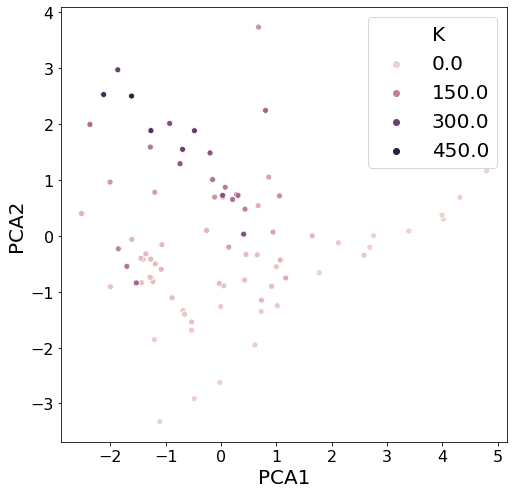

In [6]:
plt.figure(figsize=(8, 8))
sns.scatterplot(z_pca[:, 0], z_pca[:, 1], hue=y)
plt.legend(loc="best")
plt.xlabel("PCA1")
plt.ylabel("PCA2");

We can do a linear regression on the first two PCA components instead of all four variables.

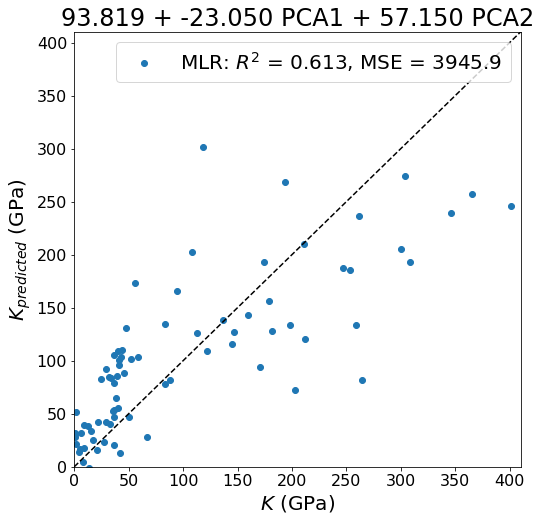

In [7]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

mlr = linear_model.LinearRegression()
yhat_mlr = cross_val_predict(mlr, z_pca[:, 0:2], y, cv=kfold)
r2_mlr = r2_score(y, yhat_mlr)
mae_mlr = mean_squared_error(y, yhat_mlr)
label_mlr = "MLR: $R^2$ = %.3f, MSE = %.1f" % (r2_mlr, mae_mlr)

f, ax = plt.subplots(figsize=(8, 8))
plt.plot(y, yhat_mlr, 'o', label=label_mlr)
l = plt.ylabel("$K_{predicted}$ (GPa)")
l = plt.xlabel("$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], 'k--')

mlr.fit(z_pca[:, 0:2], y)
equation = "%.3f + %.3f PCA1 + %.3f PCA2" % (mlr.intercept_, *mlr.coef_)
plt.title(equation);

If you compare to the results obtained from Lecture 02 - Linear Methods, you can see that the R2 and MSE has significantly improved from the non-regularized regression and much closer to what was obtained using ridge and LASSO.

Let's see what happens when we do a lasso on the full PCA.

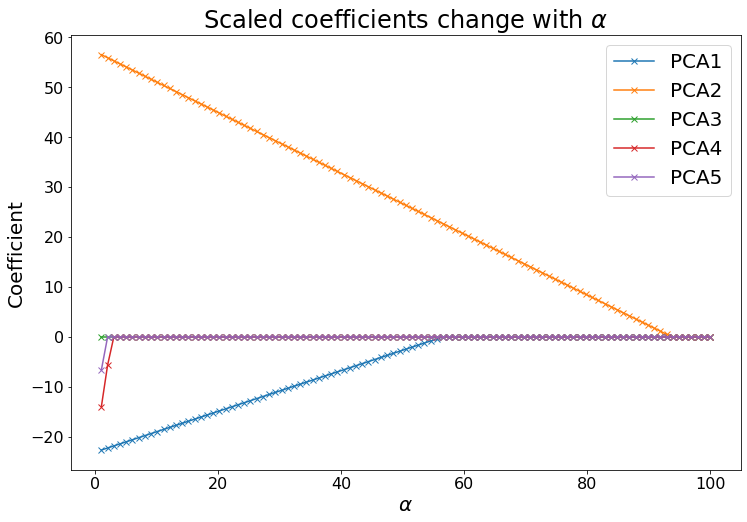

In [8]:
from sklearn.model_selection import cross_validate

features = ["PCA%d" % (i+1) for i in range(5)]
alphas = np.linspace(1, 100, 99)
cv_results = []
coeffs = []
for alpha in alphas:
    lasso = linear_model.Lasso(alpha=alpha, max_iter=100000)
    lasso.fit(z_pca, y)
    scores = cross_validate(lasso, z_pca, y, cv=kfold, scoring='neg_mean_squared_error')
    cv_results.append([alpha, -np.mean(scores["test_score"])] + list(lasso.coef_))

cv_results = pd.DataFrame(cv_results, columns=["alpha", "score"] + features)
f, ax = plt.subplots(figsize=(12, 8))
for f in features:
    plt.plot(cv_results["alpha"], cv_results[f], '-x', label=f)
    #plt.xscale('log')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Coefficient')
    plt.title(r'Scaled coefficients change with $\alpha$')
plt.legend();

Notice that for LASSO on the PCA components, which are orthogonal by definition, the behavior of the coefficients are very well-behaved. Each coefficient is translated down with increasing shrinkage parameter alpha, and truncated at zero. 

# Clustering

You will be playing around with clustering in an actual materials problem in lab 2. To avoid spoiling the surprise, we will here use an artificial dataset that we generate using numpy to demonstrate how to do clustering. We generate data that contains random 2D data points centered at three centers - (0, 0), (0, 5), (5, 0) - with variance of 0.8 to 1.5.

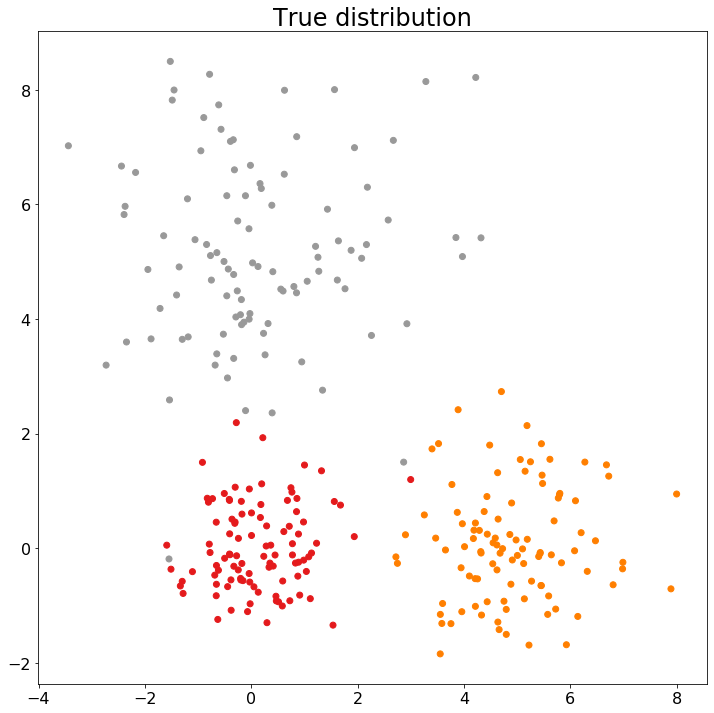

In [9]:
import numpy as np

data = []
centers = [[0, 0], [5, 0], [0, 5]]
stds = [0.75, 1, 1.5]
labels = []
fig, ax = plt.subplots(figsize=(12, 12))
for i, (c, std) in enumerate(zip(centers, stds)):
    points = np.random.randn(100, 2) * std + c
    labels.extend([i] * 100)
    data.extend(points)
data = np.array(data)
ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='Set1')
ax.set_title("True distribution")
np.savetxt("3_gaussians.txt", data)

## K-means

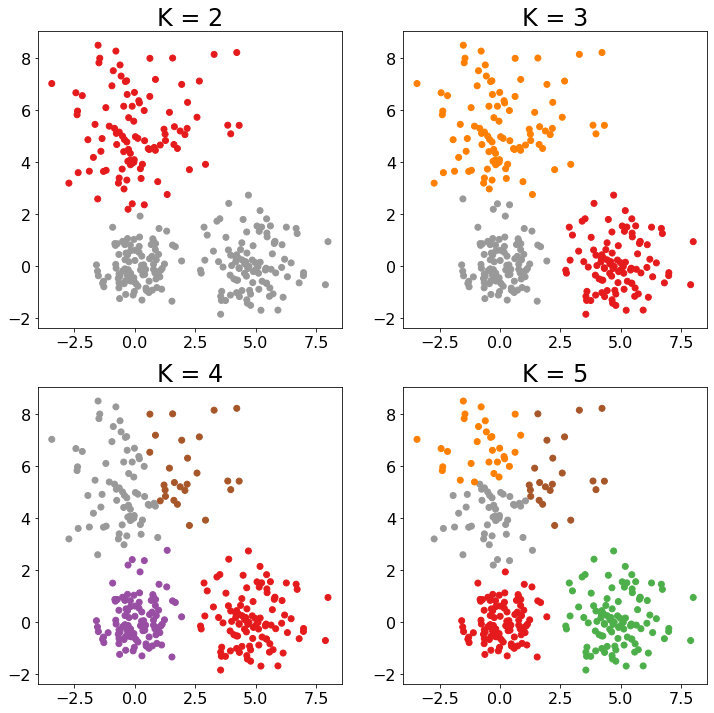

In [10]:
from sklearn.cluster import KMeans

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for i, k in enumerate(range(2, 6)):
    clustering = KMeans(k).fit(data)
    a = ax[0 if i < 2 else 1, i % 2]
    a.scatter(data[:, 0], data[:, 1], c=clustering.labels_, cmap='Set1')
    a.set_title("K = %d" % k)

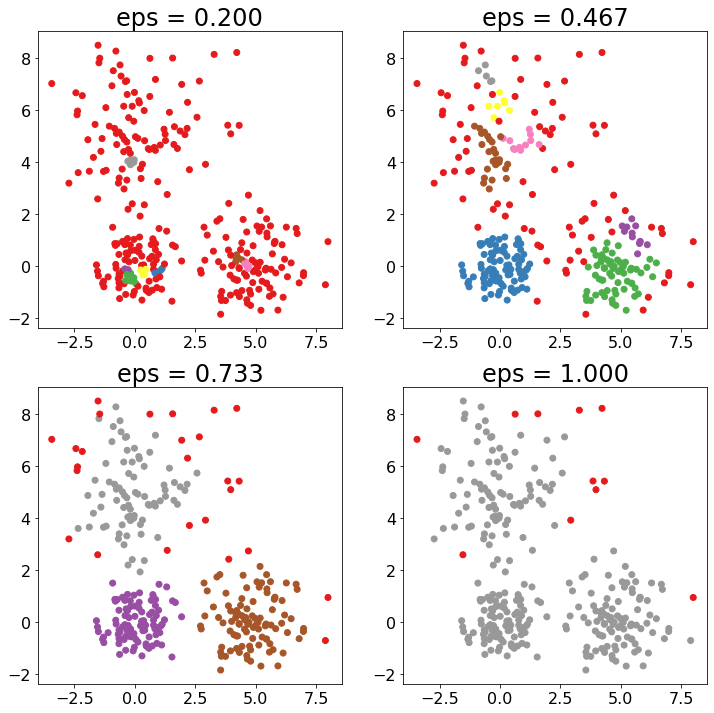

In [11]:
from sklearn.cluster import DBSCAN

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for i, eps in enumerate(np.linspace(0.2, 1, 4)):
    clustering = DBSCAN(eps=eps).fit(data)
    a = ax[0 if i < 2 else 1, i % 2]
    a.scatter(data[:, 0], data[:, 1], c=clustering.labels_, cmap='Set1')
    a.set_title("eps = %.3f" % eps)

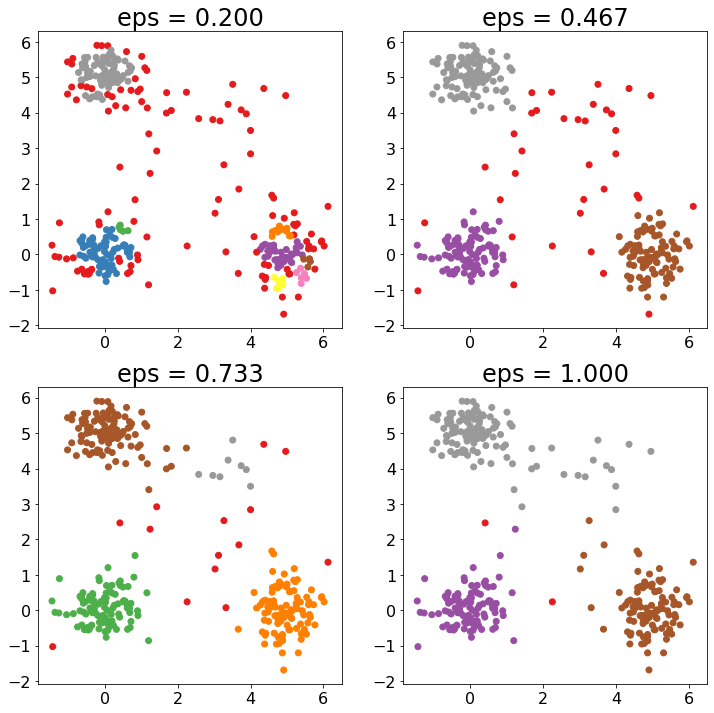

In [12]:
data = []
centers = [[0, 0], [5, 0], [0, 5]]
stds = [0.5, 0.5, 0.5]
labels = []
for i, (c, std) in enumerate(zip(centers, stds)):
    points = np.random.randn(100, 2) * std + c
    labels.extend([i] * 100)
    data.extend(points)
noise = np.random.rand(30, 2) * 5
data.extend(noise)
data = np.array(data)

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
for i, eps in enumerate(np.linspace(0.2, 1, 4)):
    clustering = DBSCAN(eps=eps).fit(data)
    a = ax[0 if i < 2 else 1, i % 2]
    a.scatter(data[:, 0], data[:, 1], c=clustering.labels_, cmap='Set1')
    a.set_title("eps = %.3f" % eps)